# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
#from items import Item
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.items import Item 
#from loaders import ItemLoader
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.loaders import ItemLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [9]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [10]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

Dell Optiplex Small form factor (SFF) Business Desktop PC, Intel Quad-Core 3.4 GHz Processor, 512GB SSD, 8GB DDR4, Ethernet, USB 3.0, DVD±RW, Display Port/HDMI, Win 10 Pro, With Keyboard+Mouse
The DELL OptiPlex 3050 is one of the world’s most secure, manageable and reliable desktops. Though small in size, it’s loaded with enterprise-level power and features, like the state-of-the-art 7th Intel Core processors, best-in-class security and manageability, flexibility for dual orientation, expandability options as well as multiple display support. 512GB SSD with nvme PCIe technology gives you the fastest read/write speed. SSD is resulting

Price is $456.00


In [11]:
# Remind a test prompt

print(train[0].price)

456.35


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [12]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [13]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $13.99 Error: $641.01 SLE: 14.28 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $115.00 Truth: $699.00 Error: $584.00 SLE: 3.23 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $26.00 Truth: $69.99 Error: $43.99 SLE: 0.93 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $760.00 Truth: $64.95 Error: $695.05 SLE: 5.98 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $282.00 Truth: $110.90 Error: $171.10 SLE: 0.86 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $251.00 Truth: $5.99 Error: $245.01 SLE: 12.85 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $229.00 Truth: $529.00 Error: $300.00 SLE: 0.70 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $143.00 Truth: $14.98 Error: $128.02 SLE: 4.83 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $755.00 Truth: $113.99 Error: $641.01 SLE: 3.55 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $105.00 Truth: $829.99 

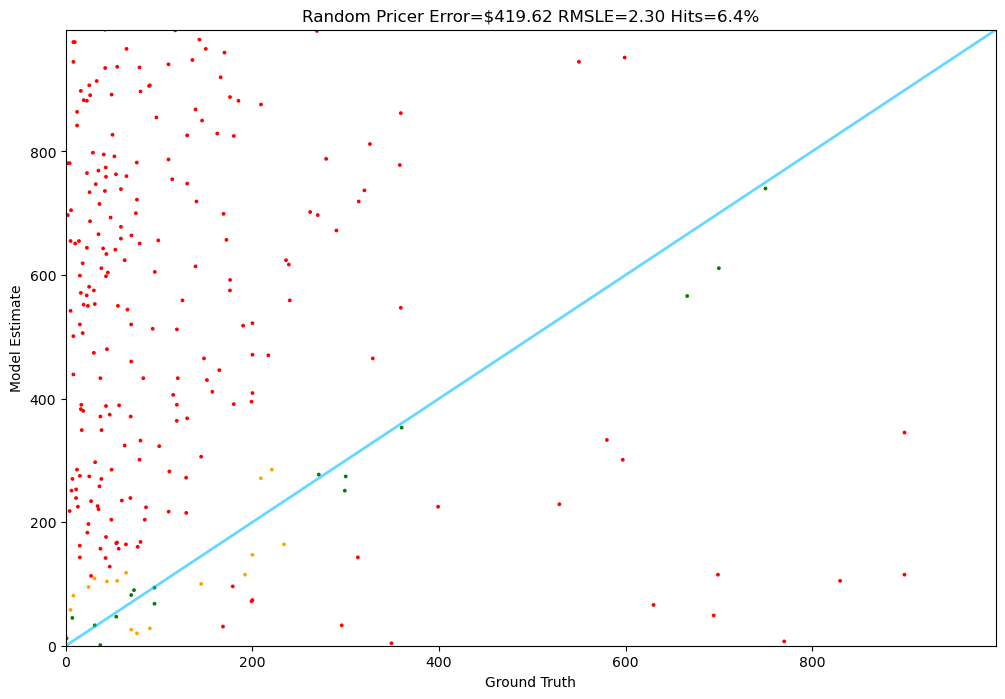

In [14]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [15]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $159.71 Truth: $13.99 Error: $145.72 SLE: 5.63 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $159.71 Truth: $699.00 Error: $539.29 SLE: 2.17 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $159.71 Truth: $69.99 Error: $89.72 SLE: 0.67 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $159.71 Truth: $64.95 Error: $94.76 SLE: 0.79 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $159.71 Truth: $110.90 Error: $48.81 SLE: 0.13 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $159.71 Truth: $5.99 Error: $153.72 SLE: 9.83 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $159.71 Truth: $529.00 Error: $369.29 SLE: 1.42 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $159.71 Truth: $14.98 Error: $144.73 SLE: 5.33 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $159.71 Truth: $113.99 Error: $45.72 SLE: 0.11 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $159.71 Truth: $829.99 Erro

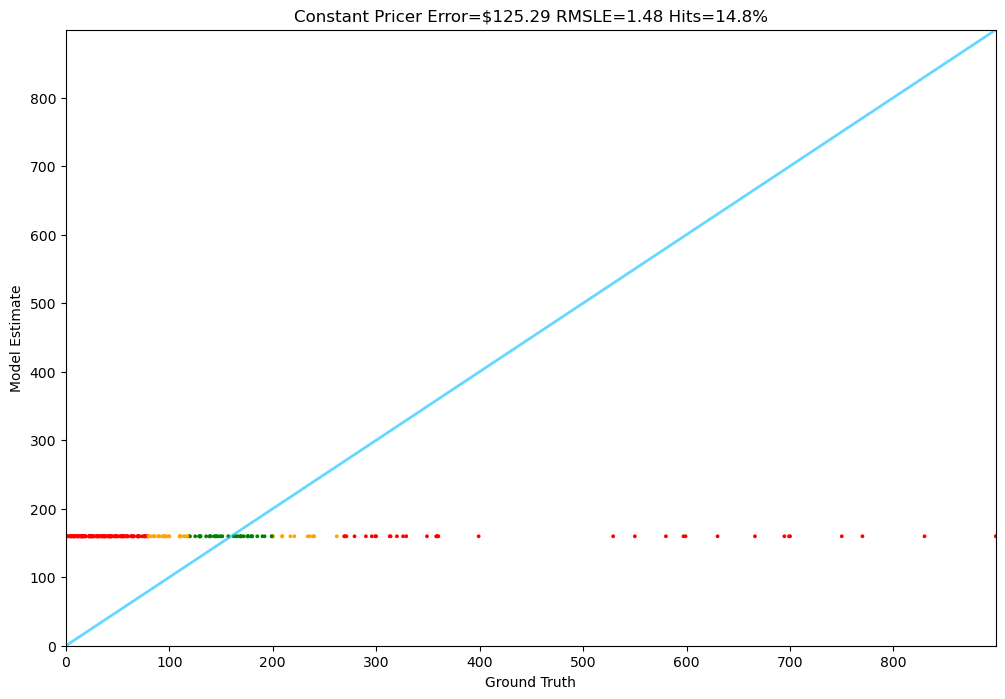

In [16]:
# Run our constant predictor
Tester.test(constant_pricer)


In [17]:
train[0].details

'{"Processor": "3.4 GHz core_i5", "RAM": "8 GB DDR4", "Hard Drive": "512 GB SSD", "Graphics Coprocessor": "Intel HD Graphics 630", "Chipset Brand": "Intel", "Card Description": "Integrated", "Brand": "Dell", "Series": "Optiplex-i5-512SSD", "Item model number": "Optiplex-i5-512SSD", "Hardware Platform": "PC", "Operating System": "Windows 10 Professional", "Item Weight": "9 pounds", "Product Dimensions": "11.4 x 3.6 x 11.5 inches", "Item Dimensions  LxWxH": "11.4 x 3.6 x 11.5 inches", "Color": "black", "Processor Brand": "Intel", "Number of Processors": "4", "Computer Memory Type": "DDR SDRAM", "Hard Drive Interface": "Solid State", "Optical Drive Type": "DVD\\u00b1RW", "Best Sellers Rank": {"Computers & Accessories": 100988, "Tower Computers": 4032}, "Date First Available": "July 17, 2018", "Specific Uses For Product": "Business", "Memory Storage Capacity": "512 GB", "Ram Memory Installed Size": "8 GB", "Model Name": "Optiplex-i5-512SSD", "Included Components": "Mouse, Keybord", "CPU Mo

In [18]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [19]:
train[0].features.keys()

dict_keys(['Processor', 'RAM', 'Hard Drive', 'Graphics Coprocessor', 'Chipset Brand', 'Card Description', 'Brand', 'Series', 'Item model number', 'Hardware Platform', 'Operating System', 'Item Weight', 'Product Dimensions', 'Item Dimensions  LxWxH', 'Color', 'Processor Brand', 'Number of Processors', 'Computer Memory Type', 'Hard Drive Interface', 'Optical Drive Type', 'Best Sellers Rank', 'Date First Available', 'Specific Uses For Product', 'Memory Storage Capacity', 'Ram Memory Installed Size', 'Model Name', 'Included Components', 'CPU Model', 'Special Feature'])

In [20]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 113953),
 ('Item Weight', 104434),
 ('Brand', 99694),
 ('Manufacturer', 97445),
 ('Best Sellers Rank', 97185),
 ('Item model number', 87938),
 ('Product Dimensions', 75202),
 ('Color', 53552),
 ('Is Discontinued By Manufacturer', 47586),
 ('Special Feature', 34177),
 ('Compatible Devices', 32399),
 ('Country of Origin', 31795),
 ('Package Dimensions', 28943),
 ('Connectivity Technology', 26416),
 ('Model Name', 21262),
 ('Item Dimensions  LxWxH', 20797),
 ('Batteries', 18925),
 ('Item Dimensions LxWxH', 16341),
 ('Screen Size', 15930),
 ('Material', 15107),
 ('Operating System', 13642),
 ('Series', 13469),
 ('Standing screen display size', 12911),
 ('RAM', 12473),
 ('Voltage', 12220),
 ('Included Components', 11981),
 ('Hard Drive', 11735),
 ('Power Source', 11681),
 ('Computer Memory Type', 11333),
 ('Hardware Platform', 11278),
 ('Processor Brand', 10484),
 ('Number of Processors', 10422),
 ('Connector Type', 10209),
 ('Processor', 10097),
 ('Chipset Brand',

In [21]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [22]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [23]:
average_weight = sum(weights)/len(weights)
average_weight

4.393633592580455

In [24]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [25]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [26]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

67883.84838426959

In [27]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [28]:
def get_text_length(item):
    return len(item.test_prompt())

In [29]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 3749),
 ('Dell', 2686),
 ('Lenovo', 2015),
 ('Sony', 1311),
 ('SAMSUNG', 1198),
 ('ASUS', 1158),
 ('Canon', 713),
 ('Intel', 641),
 ('Apple', 587),
 ('Garmin', 496),
 ('Nikon', 452),
 ('GODOX', 447),
 ('Pyle', 423),
 ('Logitech', 408),
 ('A-Tech', 403),
 ('Microsoft', 390),
 ('Panasonic', 386),
 ('Generic', 381),
 ('MSI', 367),
 ('LG', 357),
 ('Western Digital', 343),
 ('UPBRIGHT', 308),
 ('Seagate', 307),
 ('Kastar', 300),
 ('Harmony Audio', 297),
 ('Acer', 291),
 ('KICKER', 290),
 ('Fujifilm', 285),
 ('Plantronics', 270),
 ('NETGEAR', 262),
 ('Corsair', 260),
 ('Monoprice', 254),
 ('JBL', 254),
 ('Neewer', 251),
 ('SanDisk', 249),
 ('Gigabyte', 249),
 ('Olympus', 245),
 ('AmScope', 239),
 ('Tripp Lite', 230),
 ('Kate', 217)]

In [30]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [31]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [32]:
# Look at features in a training item
get_features(train[0])

{'weight': 9.0,
 'rank': 52510.0,
 'text_length': 701,
 'is_top_electronics_brand': 1}

In [33]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [34]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.8664922030403632
rank: 1.7126425444584847e-05
text_length: -0.07928912517344468
is_top_electronics_brand: 212.20136802867037
Intercept: 188.8106323215569
Mean Squared Error: 25275.432241324448
R-squared Score: 0.11380133502807444


In [35]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $123.20 Truth: $13.99 Error: $109.21 SLE: 4.47 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $345.07 Truth: $699.00 Error: $353.93 SLE: 0.50 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $144.08 Truth: $69.99 Error: $74.09 SLE: 0.51 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $132.52 Truth: $64.95 Error: $67.57 SLE: 0.50 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $128.50 Truth: $110.90 Error: $17.60 SLE: 0.02 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $132.21 Truth: $5.99 Error: $126.22 SLE: 8.69 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $339.60 Truth: $529.00 Error: $189.40 SLE: 0.20 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $139.56 Truth: $14.98 Error: $124.58 SLE: 4.73 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $143.84 Truth: $113.99 Error: $29.85 SLE: 0.05 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $369.35 Truth: $829.99 Erro

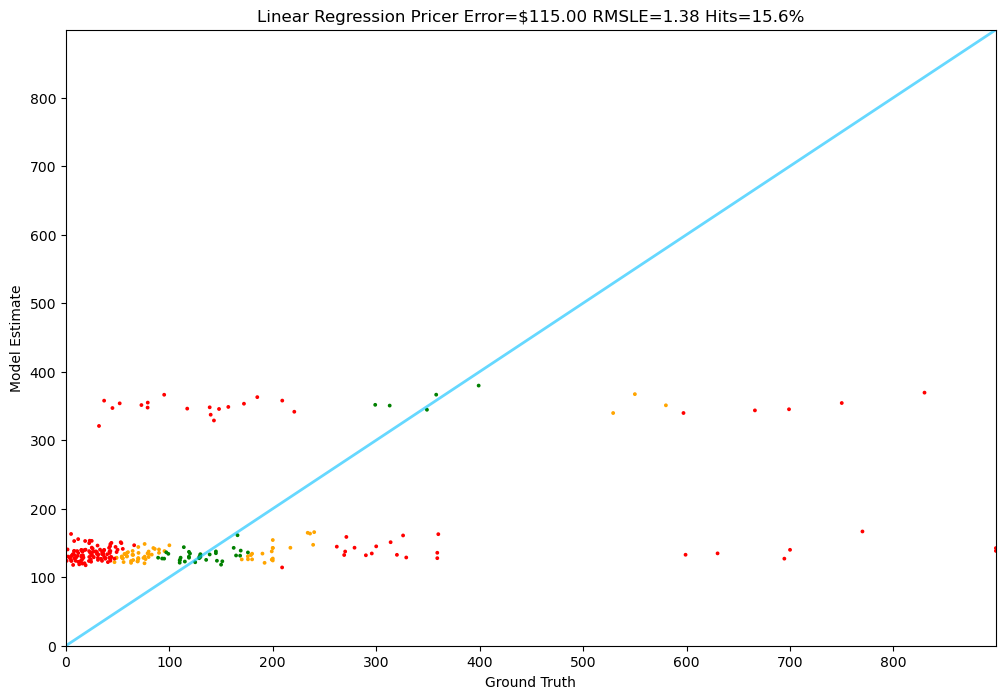

In [36]:
# test it

Tester.test(linear_regression_pricer)

In [37]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [38]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [39]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $7.88 Truth: $13.99 Error: $6.11 SLE: 0.27 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $225.39 Truth: $699.00 Error: $473.61 SLE: 1.27 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $187.87 Truth: $69.99 Error: $117.88 SLE: 0.96 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $243.74 Truth: $64.95 Error: $178.79 SLE: 1.72 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $36.66 Truth: $110.90 Error: $74.24 SLE: 1.19 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $0.00 Truth: $5.99 Error: $5.99 SLE: 3.78 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $350.83 Truth: $529.00 Error: $178.17 SLE: 0.17 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $2.90 Truth: $14.98 Error: $12.08 SLE: 1.99 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $95.16 Truth: $113.99 Error: $18.83 SLE: 0.03 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $748.10 Truth: $829.99 Error: $81.89 S

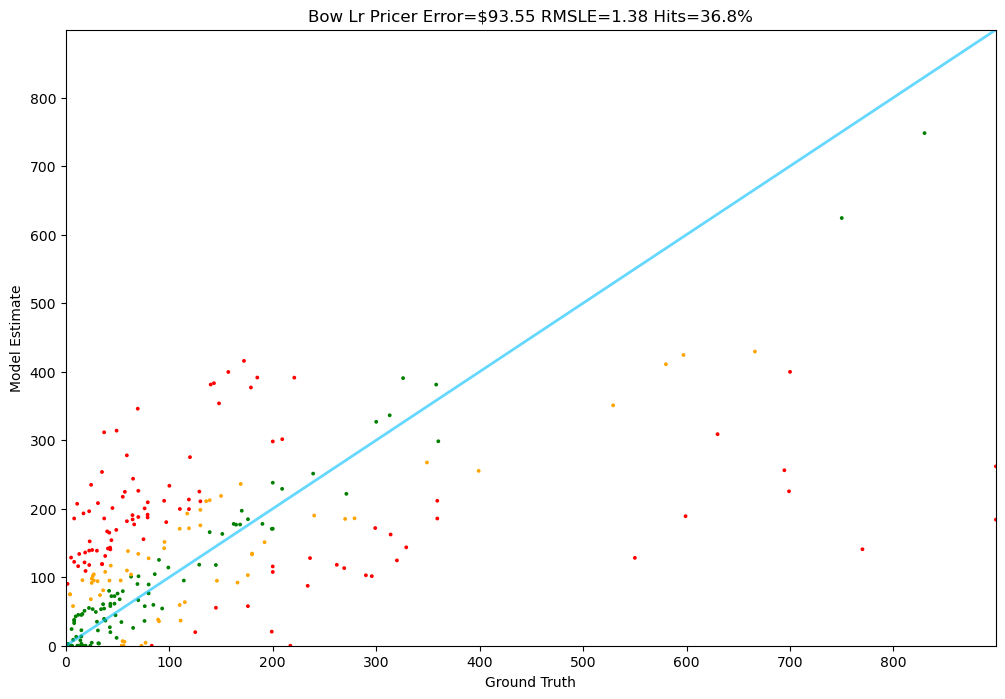

In [40]:
# test it

Tester.test(bow_lr_pricer)

In [ ]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [ ]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [ ]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

In [ ]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

In [ ]:
Tester.test(word2vec_lr_pricer)

In [ ]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

In [ ]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

In [ ]:
Tester.test(svr_pricer)

In [ ]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)